In [1]:
from IPython.core.display import HTML
with open('../style.css') as f:
    css = f.read()
HTML(css)

# A Backtracking Solver with Constraint Propagation

## Utility Functions

The module `extractVariables` implements the function $\texttt{extractVars}(e)$ that takes a *Python* expression $e$ as its argument and returns the set of all variables and function names occurring in $e$.

In [2]:
import extractVariables as ev

The function `collect_variables(expr)` takes a string `expr` that can be interpreted as a Python expression as input and collects all variables occurring in `expr`.  It takes care to eliminate the function symbols from the names returned by `extract_variables`.

In [3]:
def collect_variables(expr):
    return frozenset(var for var in ev.extractVars(expr)
                         if  var not in dir(__builtins__)
                    )

The function `arb(S)` takes a set `S` as input and returns an arbitrary element from 
this set.

In [4]:
def arb(S):
    for x in S:
        return x

Backtracking is simulated by raising the `Backtrack` exception.  We define this new class of exceptions so that we can distinguish `Backtrack` exceptions from ordinary exceptions.  This is done by creating a new, empty class that is derived from the class `Exception`.  

In [5]:
class Backtrack(Exception):
    pass

Given a list of sets `L`, the function `union(L)` returns the set of all elements occurring in some set $S$ that is itself a member of the list `L`, i.e. we have
$$ \texttt{union}(L) = \{ x \mid \exists S \in L : x \in L \}. $$ 

In [6]:
def union(L):
    return { x for S in L
               for x in S
           }

In [7]:
union([ {1, 2}, {'a', 'b'}, {1, 'a'} ])

{1, 2, 'a', 'b'}

## The Constraint Propagation Solver

The procedure $\texttt{solve}(\mathcal{P})$ takes a a *constraint satisfaction problem* 
$\mathcal{P}$ as input.  Here $\mathcal{P}$ is a triple of the form 
$$ \mathcal{P} = \langle \mathtt{Variables}, \mathtt{Values}, \mathtt{Constraints} \rangle $$
where 
- `Variables` is a set of strings which serve as *variables*,
- `Values` is a set of *values* that can be assigned to the variables in the set `Variables`.
- `Constraints` is a set of *formulas* from first order logic.  
   Each of these formulas is  called a *constraint* of $\mathcal{P}$.
  
Initially, the function `solve` checks that the constraints do not contain any variables that are not 
elements of the set `Variables`.  Furthermore, it checks that all variables in `Variables` do indeed occur 
in one of the constraints.  These two checks are neccessary to capture spelling mistakes.

Then, the function `solve` converts the CSP $\mathcal{P}$ into an *augmented CSP* where every constraint $f$ is annotated with the variables occurring in $f$.  The most important data structure maintained by `solve` is the dictionary `ValuesPerVar`.  For every variable $x$ occurring in a constraint of `P`, the expression $\texttt{ValuesPerVar}(x)$ is the set of values that can be used to instantiate the variable $x$.  Initially, 
$\texttt{ValuesPerVar}(x)$ is set to `Values`, but as the search for a solution proceeds, the sets $\texttt{ValuesPerVar}(x)$ are reduced by removing any values that cannot be part of a solution.
This way, the consequences of binding one variable to a value are *propagated* to the other variables.

Next, the function `solve` divides the constraints into two groups:
- The *unary* constraints are those constraint that contain only a single variable.

  The unary constraints can be solved immediately: 
  If $f$ is a unary constraint containing only the variable $x$, the set $\texttt{ValuesPerVar}(x)$ 
  is reduced to the set of those values $v$ such that $\texttt{eval}(f, \{x\mapsto v\})$ is true.
- The remaining constraints contain at least two different variables.

After the unary constraints have been taken care of, `backtrack_search` is called to solve the remaining constraint satisfaction problem.  The function `backtrack_search` uses both *backtracking* and *constraint propagation* to solve the remaining constraints.

In [8]:
def solve(P):
    Variables, Values, Constraints = P
    VarsInConstrs  = union([ collect_variables(f) for f in Constraints ])
    MisspelledVars = (VarsInConstrs - Variables) | (Variables - VarsInConstrs)
    if len(MisspelledVars) > 0:
        print('Did you misspell any of the following Variables?')
        for v in MisspelledVars:
            print(v)
    Annotated    = { (f, collect_variables(f)) for f in Constraints }
    ValuesPerVar = { v: Values for v in Variables }
    UnaryConstrs = { (f, V) for f, V in Annotated
                            if  len(V) == 1
                   }
    OtherConstrs = { (f, V) for f, V in Annotated
                            if  len(V) >= 2
                   }
    try:
        for f, V in UnaryConstrs:
            var = arb(V)
            ValuesPerVar[var] = solve_unary(f, var, ValuesPerVar[var])
        return backtrack_search({}, ValuesPerVar, OtherConstrs)
    except Backtrack:
        return None

The function `solve_unary` takes a unary constraint `f`, a variable `x` and the set of values `Values` that can be assigned to `x`.  It returns the subset of those values `v` that can be substituted for `x` such that $\texttt{eval}(f, \{ x \mapsto v \})$ evaluates as `True`.  If the unary constraint `f` is unsolvable, then the given CSP is unsolvable and an exception is raised. 

In [9]:
def solve_unary(f, x, Values):
    Legal = { value for value in Values 
                    if  eval(f, { x: value })
            }
    if len(Legal) == 0:
        raise Backtrack()
    return Legal

The function `backtrack_search` takes three arguments:
- `Assignment` is a partial variable assignment that is represented as a
   dictionary.  Initially, this assignment will be the  empty dictionary.     
   Every recursive call of `backtrack_search` adds the assignment of one 
   variable to  the given assignment. 
- `ValuesPerVar` is a dictionary.  For every variable `x`, `ValuesPerVar[x]` is the set of values that still might be assigned to `x`.
- `Constraints` is a set of pairs of the form `(F, V)` where `F` is a constraint and `V` is the set of variables occurring in `V`.

The function tries to solve the given CSP via backtracking.  Instead of picking the variables arbitrarily, it uses 
the *most constraint variable* heuristic and therefore instantiates those variables first, that have the least
remaing values.  This way, a dead end in the search is discovered sooner.

In [11]:
def backtrack_search(Assignment, ValuesPerVar, Constraints):
    # print(Assignment)
    if len(Assignment) == len(ValuesPerVar):
        return Assignment
    x = most_constrained_variable(Assignment, ValuesPerVar)
    for v in ValuesPerVar[x]:
        try:
            if is_consistent(x, v, Assignment, Constraints):
                NewValues    = propagate(x, v, Assignment, Constraints, ValuesPerVar)
                NewAssign    = Assignment.copy()
                NewAssign[x] = v
                return backtrack_search(NewAssign, NewValues, Constraints)
        except Backtrack:
            continue
    raise Backtrack()

The function `most_constrained_variable` takes two parameters:
- `Assignment` is a *partial variable assignment* that assigns values to variables.  It is represented as a dictionary.
- `ValuesPerVar` is a dictionary that maps variables to the set of values that may be assigned to these variables,
  i.e. for every variable `x`, `ValuesPerVar[x]` is the set of values that can be assigned to the variable `x`
  without violating a constraint.
  
The function returns an unassigned variable `x` such that the number of values in `ValuesPerVar[x]` is minimal among all other unassigned variables.

In [12]:
def most_constrained_variable(Assignment, ValuesPerVar):
    Unassigned = { (x, len(U)) for x, U in ValuesPerVar.items()
                               if  x not in Assignment
                 }
    minSize = min(lenU for _, lenU in Unassigned)
    return arb({ x for x, lenU in Unassigned if lenU == minSize })

The function `propagate` takes five arguments:
- `x` is a variable,
- `v` is a value that is supposed to be assigned to `x`.
- `Assignment` is a partial assignment that contains assignments for variables that are different from `x`.
- `Constraints` is a set of annotated constraints.
- `ValuesPerVar` is a dictionary assigning sets of values to all variables.  For every unassigned variable `z`,  `ValuesPerVar[z]` is the set of values that still might be assigned to `z`.

The purpose of the function  `propagate` is to compute how the sets `ValuesPerVar[z]` can be shrunk when the value `v` is assigned to the variable `x`.  The dictionary `ValuesPerVar` with appropriately reduced sets `ValuesPerVar[z]` is returned.  In particular, the consequences of assigning the value `v` to the variable `x` are *propagated*:
If there is a constraint `f` such that `x` occurs in `f` and there is just one variable `y` left that occurs in 
`f` and that is not yet bound in `Assignment`, then the values that can still be assigned to `y` are computed
and the dictionary `ValuesDict` is updated accordingly.  If there are no values left that can be assigned to 
`y` without violating the constraint `f`, the function backtracks.

In [13]:
def propagate(x, v, Assignment, Constraints, ValuesPerVar):
    ValuesDict    = ValuesPerVar.copy()
    ValuesDict[x] = { v }
    BoundVars     = set(Assignment.keys())
    for f, Vars in Constraints:
        if x in Vars:
            UnboundVars = Vars - BoundVars - { x }
            if len(UnboundVars) == 1:
                y = arb(UnboundVars)
                Legal = set()
                for w in ValuesDict[y]:
                    NewAssign = Assignment.copy()
                    NewAssign[x] = v
                    NewAssign[y] = w
                    if eval(f, NewAssign):
                        Legal.add(w)
                if len(Legal) == 0:
                    raise Backtrack()
                ValuesDict[y] = Legal
    return ValuesDict

The function $\texttt{is_consistent}(\texttt{var}, \texttt{value}, \texttt{Assignment}, \texttt{csp})$ takes four arguments:
* `var` is a variable that does not occur in `Assignment`,
* `value` is a value that can be substituted for this variable,
* `Assignment` is a *consistent* partial variable assignment.         
  A partial variable assignment $A$ is *consistent* if all
  constraints $f$ that contain only variables from the set $\mathtt{dom}(A)$ are satisfied.
* `csp` is an *augmented* constraint satisfaction problem.

This function returns `True` iff the partial variable assignment 
$$\texttt{Assignment} \cup \{\langle\texttt{var} \mapsto\texttt{value}\rangle\}$$
is consistent with all the constraints occurring in `csp`.

In [14]:
def is_consistent(var, value, Assignment, Constraints):
    NewAssign      = Assignment.copy()
    NewAssign[var] = value
    return all(eval(f, NewAssign) for (f, Vs) in Constraints
                                  if  var in Vs and Vs <= NewAssign.keys()
              )

## Solving the *Eight-Queens-Puzzle*

In [15]:
%run N-Queens-Problem-CSP.ipynb

Variables:   {'V4', 'V2', 'V1', 'V3'}
Values:      {1, 2, 3, 4}
Constraints:
             abs(V4 - V1) != 3
             V1 != V4
             V2 != V4
             V2 != V3
             V1 != V3
             V3 != V4
             V1 != V2
             abs(V4 - V3) != 1
             abs(V4 - V2) != 2
             abs(V3 - V2) != 1
             abs(V3 - V1) != 2
             abs(V2 - V1) != 1


In [16]:
P = create_csp(8)

Constraint Propagation takes about 11 milliseconds on my desktop to solve the eight queens puzzle.

In [18]:
%%time
Solution = solve(P)
print(f'Solution = {Solution}')

Solution = {'V1': 1, 'V4': 3, 'V5': 7, 'V6': 4, 'V2': 6, 'V8': 5, 'V3': 8, 'V7': 2}
CPU times: user 23.1 ms, sys: 474 µs, total: 23.6 ms
Wall time: 23.2 ms


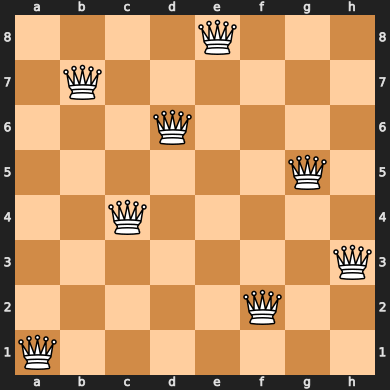

In [19]:
show_solution(Solution)

In [20]:
P = create_csp(16)

Constraint propagation can solve the 16 queens problem in less than $0.1$ seconds.

In [21]:
%%time
Solution = solve(P)
print(f'Solution = {Solution}')

Solution = {'V14': 1, 'V10': 2, 'V1': 3, 'V4': 4, 'V7': 6, 'V13': 7, 'V11': 8, 'V15': 11, 'V3': 13, 'V6': 12, 'V5': 9, 'V9': 14, 'V8': 16, 'V16': 5, 'V2': 15, 'V12': 10}
CPU times: user 118 ms, sys: 3.52 ms, total: 122 ms
Wall time: 123 ms


## Solving the *Zebra Puzzle*

In [22]:
%run Zebra.ipynb

In [ ]:
zebra = zebra_csp()

Constraint propagation takes about 20 milliseconds to solve the *Zebra Puzzle*.

In [ ]:
%%time
Solution = solve(zebra)

In [ ]:
show_solution(Solution)

## Solving a Sudoku Puzzle

In [ ]:
%run Sudoku.ipynb

In [ ]:
csp = sudoku_csp(Sudoku)
csp

Constraint propagation takes about 210 milliseconds to solve the given sudoku.

In [ ]:
%%time
Solution = solve(csp)

In [ ]:
show_solution(Solution)

# Solving the Crypto-Arithmetic Puzzle

In [ ]:
%run Crypto-Arithmetic.ipynb

In [ ]:
csp = crypto_csp()

Constraint propagation takes about four seconds to solve the crypto-arithmetic puzzle.

In [ ]:
%%time
Solution = solve(csp)

In [ ]:
show_solution(Solution)